In [170]:
import os
import json
import wandb
import itertools
import numpy as np
from time import gmtime, strftime
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch
import torchaudio
import torchaudio.transforms as transforms
import torch.nn.functional as F

import sys
sys.path.append('../training')
from utils import utils, data_utils, audio_utils
from hyface import Nansy, BShall_Ecapa, BShall_Nimbre
from speechbrain.pretrained import EncoderClassifier

from networks.timbre import TimbreEncoder
from networks.bshall import AcousticModel
from networks.discriminator import Discriminator
from datasets.f2v_loader import F2V_Dataset

import IPython.display as ipd

In [18]:
import timm

In [19]:
from timm.models.layers import to_2tuple, trunc_normal_, DropPath
from timm.models.vision_transformer import Attention, Mlp, PatchEmbed, Block

In [2]:
# main_dir = '/home/jaejun/nansy/
config_path = '../training/configs/f2v.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

# Data

In [9]:
trainset = F2V_Dataset(args, meta_root='../training/filelists/VGG_Face', mode='train', img_datasets=['VGG_Face_Spk'], sample_rate=args.data.sample_rate)
train_loader = DataLoader(trainset, batch_size=4, shuffle=True)

In [8]:
img, aud = trainset[0]
print(img.shape, aud.shape)

torch.Size([3, 224, 224]) (64000,)


In [158]:
img, aud = next(iter(train_loader))
print(img.shape, aud.shape)

torch.Size([4, 3, 224, 224]) torch.Size([4, 64000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


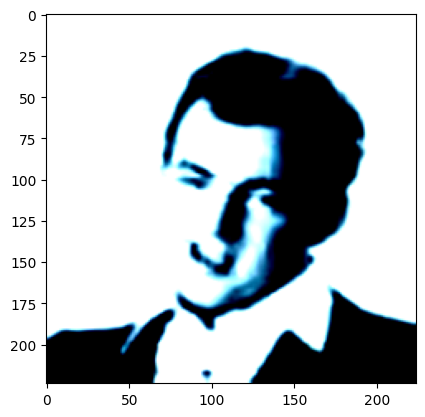

In [159]:
plt.imshow(img[0].permute(1,2,0))

In [160]:
ipd.Audio(aud[0], rate=16000)

# Model

In [171]:
class LogMelSpectrogram(torch.nn.Module):
    def __init__(self, sample_rate, n_fft, hop_length, win_length, n_mels, center):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.melspctrogram = transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            center=center,
            power=1.0,
            norm="slaney",
            onesided=True,
            n_mels=n_mels,
            mel_scale="slaney",
        )

    def forward(self, wav):
        wav = F.pad(wav, ((self.n_fft - self.hop_length) // 2, (self.n_fft - self.hop_length) // 2), "reflect")
        mel = self.melspctrogram(wav)
        logmel = torch.log(torch.clamp(mel, min=1e-5))
        return logmel.squeeze(0)

class F2V_Ecapa(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.logmel = LogMelSpectrogram(sample_rate=args.data.sample_rate, n_fft=args.features.mel.win,
                hop_length=args.features.mel.hop, win_length=args.features.mel.win, n_mels=args.features.mel.bin, center=False)
        self.classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", run_opts=None)

    @torch.no_grad()
    def analyze_timbre(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Analyze the timber informations from inputs.
        Args:
            inputs: [torch.float32; [B, T]], input speech signal.
        Returns:
            [torch.float32; [B, timb_global]], global timber emebddings.
            [torch.float32; [B, timb_timber, timb_tokens]], timber token bank.
        """
        # [B, timb_global], [B, timb_timber, timb_tokens]
        embeddings = self.classifier.encode_batch(inputs)
        return embeddings

    def forward(self, inputs: torch.Tensor, ling: torch.Tensor) \
            -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        timbre_global = self.analyze_timbre(inputs)
        # [B, T]
        synth = self.synthesize(ling, timber_global, None)
        return synth, timber_global, timber_bank

class F2V_Nimbre(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.logmel = LogMelSpectrogram(sample_rate=args.data.sample_rate, n_fft=args.features.mel.win,
                hop_length=args.features.mel.hop, win_length=args.features.mel.win, n_mels=args.features.mel.bin, center=False)
        self.timbre = TimbreEncoder(args.features.mel.bin,
                    args.model.timbre.global_, args.model.timbre.channels, args.model.timbre.prekernels, args.model.timbre.scale, args.model.timbre.kernels,
                    args.model.timbre.dilations, args.model.timbre.bottleneck, args.model.timbre.hiddens, args.model.timbre.latent, args.model.timbre.timbre,
                    args.model.timbre.tokens, args.model.timbre.heads, args.model.linguistic.hiddens + args.model.timbre.global_, args.model.timbre.slerp)

    def analyze_timbre(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Analyze the timber informations from inputs.
        Args:
            inputs: [torch.float32; [B, T]], input speech signal.
        Returns:
            [torch.float32; [B, timb_global]], global timber emebddings.
            [torch.float32; [B, timb_timber, timb_tokens]], timber token bank.
        """
        # [B, mel, T / mel_hop]
        mel = self.logmel.forward(inputs)
        # [B, timb_global], [B, timb_timber, timb_tokens]
        timber_global, timber_bank = self.timbre.forward(mel)
        return timber_global, timber_bank

    def forward(self, inputs: torch.Tensor, ling: torch.Tensor) \
            -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        timber_global, timber_bank = self.analyze_timbre(inputs)
        # [B, T]
        synth = self.synthesize(ling, timber_global, timber_bank)
        return synth, timber_global, timber_bank

In [172]:
f2v_ecapa = F2V_Ecapa(args)
f2v_nimbre = F2V_Nimbre(args)

In [173]:
ecapa_emb = f2v_ecapa.analyze_timbre(aud)
print(ecapa_emb.shape)

torch.Size([4, 1, 192])


In [174]:
nimbre_emb = f2v_nimbre.analyze_timbre(aud)
print(nimbre_emb[0].shape, nimbre_emb[1].shape)

torch.Size([4, 192]) torch.Size([4, 128, 50])


# Original CAVMAE

In [38]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

def random_masking_unstructured(x, mask_ratio):
    """
    Perform per-sample random masking by per-sample shuffling.
    Per-sample shuffling is done by argsort random noise.
    x: [N, L, D], sequence
    """
    N, L, D = x.shape  # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))

    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=1)

    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)
    
    return x_masked, mask, ids_restore

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.norm1_a = norm_layer(dim)
        self.norm1_v = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_norm=False, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        self.norm2_a = norm_layer(dim)
        self.norm2_v = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, modality=None):
        if modality == None:
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        elif modality == 'a':
            x = x + self.drop_path(self.attn(self.norm1_a(x)))
            x = x + self.drop_path(self.mlp(self.norm2_a(x)))
        elif modality == 'v':
            x = x + self.drop_path(self.attn(self.norm1_v(x)))
            x = x + self.drop_path(self.mlp(self.norm2_v(x)))
        return x

### CAVMAE_encoder

In [141]:
embed_dim = 768
patch_embed_a = PatchEmbed(192, 16, 1, embed_dim)
patch_embed_a.num_patches = int(1024 * 128 / 256)
patch_embed_v = PatchEmbed(224, 16, 3, embed_dim)

pos_embed_a = nn.Parameter(torch.zeros(1, patch_embed_a.num_patches, embed_dim), requires_grad=False)  # fixed sin-cos embedding
pos_embed_v = nn.Parameter(torch.zeros(1, patch_embed_v.num_patches, embed_dim), requires_grad=False)  # fixed sin-cos embedding

modality_v = nn.Parameter(torch.zeros(1, 1, embed_dim))
blocks_a = nn.ModuleList([Block(embed_dim, 12, 4, qkv_bias=True, qk_scale=None, norm_layer=nn.LayerNorm) for i in range(11)])
blocks_v = nn.ModuleList([Block(embed_dim, 12, 4, qkv_bias=True, qk_scale=None, norm_layer=nn.LayerNorm) for i in range(11)])
blocks_u = nn.ModuleList([Block(embed_dim, 12, 4, qkv_bias=True, qk_scale=None, norm_layer=nn.LayerNorm) for i in range(12-11)])

In [142]:
print(spk_emb.shape)
temp = spk_emb.unsqueeze(1)
print(temp.shape)
aud = torch.zeros([4, 1, 128, 1024])
temp = patch_embed_a(aud)
a = temp
print(temp.shape)

torch.Size([4, 1, 192])
torch.Size([4, 1, 1, 192])
torch.Size([4, 512, 768])


In [143]:
print(img.shape)
v = patch_embed_v(img)
print(v.shape)
v = v + pos_embed_v
print(v.shape)
v = v + modality_v
print(v.shape)

torch.Size([4, 3, 224, 224])
torch.Size([4, 196, 768])
torch.Size([4, 196, 768])
torch.Size([4, 196, 768])


In [79]:
a, mask_a, ids_restore_a = random_masking_unstructured(a, 0.75)
v, mask_v, ids_restore_v = random_masking_unstructured(v, 0.75)
print(a.shape, mask_a.shape, ids_restore_a.shape)
print(v.shape, mask_v.shape, ids_restore_v.shape)

torch.Size([4, 128, 768]) torch.Size([4, 512]) torch.Size([4, 512])
torch.Size([4, 49, 768]) torch.Size([4, 196]) torch.Size([4, 196])


In [80]:
for blk in blocks_a:
    a = blk(a)
print(a.shape)

torch.Size([4, 128, 768])


In [81]:
for blk in blocks_v:
    v = blk(v)
print(v.shape)

torch.Size([4, 49, 768])


In [96]:
x = torch.cat((a,v), dim=1)
print(x.shape)

torch.Size([4, 177, 768])


In [97]:
for blk in blocks_u:
    x = blk(x)
print(x.shape)

torch.Size([4, 177, 768])


In [84]:
for blk in blocks_u:
    ca = blk(a, 'a')
print(ca.shape)

torch.Size([4, 128, 768])


In [85]:
for blk in blocks_u:
    cv = blk(v, 'v')
print(cv.shape)

torch.Size([4, 49, 768])


In [98]:
print(x.shape, mask_a.shape, ids_restore_a.shape, mask_v.shape, ids_restore_v.shape, ca.shape, cv.shape)

torch.Size([4, 177, 768]) torch.Size([4, 512]) torch.Size([4, 512]) torch.Size([4, 196]) torch.Size([4, 196]) torch.Size([4, 128, 768]) torch.Size([4, 49, 768])


### CAVMAE_decoder

In [120]:
decoder_embed_dim = 512
decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

decoder_pos_embed_a = nn.Parameter(torch.zeros(1, patch_embed_a.num_patches, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding
decoder_pos_embed_v = nn.Parameter(torch.zeros(1, patch_embed_v.num_patches, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding
print(decoder_pos_embed_a.shape, decoder_pos_embed_v.shape)

decoder_modality_a = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
decoder_modality_v = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
print(decoder_modality_a.shape, decoder_modality_v.shape)

decoder_blocks = nn.ModuleList([Block(decoder_embed_dim, 16, 4., qkv_bias=True, qk_scale=None, norm_layer=nn.LayerNorm) for i in range(8)])

patch_size = 16
decoder_pred_a = nn.Linear(decoder_embed_dim, patch_size ** 2 * 1, bias=True)  # decoder to patch
decoder_pred_v = nn.Linear(decoder_embed_dim, patch_size ** 2 * 3, bias=True)  # decoder to patch

torch.Size([1, 512, 512]) torch.Size([1, 196, 512])
torch.Size([1, 1, 512]) torch.Size([1, 1, 512])


In [99]:
x = decoder_embed(x)
print(x.shape)

torch.Size([4, 177, 512])


In [107]:
mask_tokens_a = mask_token.repeat(x.shape[0], int(mask_a[0].sum()), 1)
print(mask_tokens_a.shape)
a_ = torch.cat([x[:, :patch_embed_a.num_patches-int(mask_a[0].sum()), :], mask_tokens_a], dim=1)  # no cls token
print(a_.shape)
a_ = torch.gather(a_, dim=1, index=ids_restore_a.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
print(a_.shape)

torch.Size([4, 384, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])


In [108]:
mask_tokens_v = mask_token.repeat(x.shape[0], int(mask_v[0].sum()), 1)
print(mask_tokens_v.shape)
v_ = torch.cat([x[:, patch_embed_a.num_patches-int(mask_a[0].sum()):, :], mask_tokens_v], dim=1)  # no cls token
print(v_.shape)
v_ = torch.gather(v_, dim=1, index=ids_restore_v.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
print(v_.shape)

torch.Size([4, 147, 512])
torch.Size([4, 196, 512])
torch.Size([4, 196, 512])


In [110]:
x = torch.cat([a_, v_], dim=1)
print(x.shape)

torch.Size([4, 708, 512])


In [113]:
decoder_pos_embed = torch.cat([decoder_pos_embed_a, decoder_pos_embed_v], dim=1)
x = x + decoder_pos_embed
print(x.shape)

torch.Size([4, 708, 512])


In [115]:
x[:, 0:patch_embed_a.num_patches, :] = x[:, 0:patch_embed_a.num_patches, :] + decoder_modality_a
x[:, patch_embed_a.num_patches:, :] = x[:, patch_embed_a.num_patches:, :] + decoder_modality_v
print(x.shape)

torch.Size([4, 708, 512])


In [119]:
for blk in decoder_blocks:
    x = blk(x)
print(x.shape)

torch.Size([4, 708, 512])


In [121]:
x_a = decoder_pred_a(x[:, :patch_embed_a.num_patches, :])
x_v = decoder_pred_v(x[:, patch_embed_a.num_patches:, :])
print(x_a.shape, x_v.shape)

torch.Size([4, 512, 256]) torch.Size([4, 196, 768])


### Loss

In [123]:
def patchify(imgs, c, h, w, p=16):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    x = imgs.reshape(shape=(imgs.shape[0], c, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p ** 2 * c))
    return x

In [127]:
input = aud
target = patchify(input, 1, int(input.shape[2]/patch_embed_a.patch_size[0]), int(input.shape[3]/patch_embed_a.patch_size[1]), 16)
target.shape

torch.Size([4, 512, 256])

# Custom CAVMAE

In [176]:
print(ecapa_emb.shape)
print(nimbre_emb[0].shape, nimbre_emb[1].shape)

torch.Size([4, 1, 192])
torch.Size([4, 192]) torch.Size([4, 128, 50])


In [249]:
len(blocks_a)

3

In [258]:
blocks_a = nn.ModuleList([Block(768, 12, 4., qkv_bias=True, qk_scale=None, norm_layer=nn.LayerNorm) for i in range(8)])
blocks_v = nn.ModuleList([Block(768, 12, 4., qkv_bias=True, qk_scale=None, norm_layer=nn.LayerNorm) for i in range(8)])
blocks_u = nn.ModuleList([Block(768, 12, 4., qkv_bias=True, qk_scale=None, norm_layer=nn.LayerNorm) for i in range(4)])

In [234]:
pos_embed_a = nn.Parameter(torch.zeros(1, 1, 192), requires_grad=False)
print(f'pos_emb: {pos_embed_a.shape}')
modality_a = nn.Parameter(torch.zeros(1, 1, 192))
print(f'modality_a: {modality_a.shape}')
x_masked, mask, ids_restore = random_masking_unstructured(ecapa_emb.transpose(1,2), 0.75)
x_masked = x_masked.transpose(1,2)
print(f'masked: {x_masked.shape, mask.shape, ids_restore.shape}')

pos_emb: torch.Size([1, 1, 192])
modality_a: torch.Size([1, 1, 192])
masked: (torch.Size([4, 1, 48]), torch.Size([4, 192]), torch.Size([4, 192]))


In [257]:
a = prenet(x_masked)
print(a.shape)
for blk in blocks_a:
    a = blk(a)
print(a.shape)
a = postnet(a)
print(a.shape)

torch.Size([4, 1, 768])
torch.Size([4, 1, 768])
torch.Size([4, 1, 48])


In [263]:
decoder_embed = nn.Linear(768, 512, bias=True)

v = patch_embed_v(img)
print(v.shape)
v, mask_v, ids_restore_v = random_masking_unstructured(v, 0.75)
print(v.shape, mask_v.shape, ids_restore_v.shape)
for blk in blocks_v:
    v = blk(v)
print(v.shape)
v = decoder_embed(v)
print(v.shape)

torch.Size([4, 196, 768])
torch.Size([4, 49, 768]) torch.Size([4, 196]) torch.Size([4, 196])
torch.Size([4, 49, 768])
torch.Size([4, 49, 512])


In [265]:
mask_tokens_v = mask_token.repeat(v.shape[0], int(mask_v[0].sum()), 1)
print(mask_tokens_v.shape)

torch.Size([4, 147, 512])


In [270]:
v_ = torch.gather(mask_tokens_v, dim=1, index=ids_restore_v.unsqueeze(-1).repeat(1, 1, v.shape[2]))  # unshuffle
v_.shape

RuntimeError: index 153 is out of bounds for dimension 1 with size 147

In [268]:
mask_tokens_v = mask_token.repeat(v.shape[0], int(mask_v[0].sum()), 1)


torch.Size([4, 147, 512])


In [256]:
prenet = PreNet(48, 256, 768)
postnet = PreNet(768, 256, 48)

In [237]:
class PreNet(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        dropout: float = 0.5,
    ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_size),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)